In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sfma import Data, SFMAModel, Variable, SplineVariable, SplineGetter, SplinePriorGetter, UniformPrior

In [136]:
df = pd.read_csv("data/uhc_data.csv")
df["se"] = df.eval("sqrt(uhc_variance)")
df['log_uhc'] = np.log(df['uhc'])
df['log_uhc_se'] = df.eval("sqrt(uhc_variance)/uhc")
df['log_nurses'] = np.log(df["nurses"])
df['log_physicians'] = np.log(df["physicians"])

In [137]:
df.head(5)

,location_id,year_id,physicians,nurses,uhc,uhc_variance,se,log_uhc,log_uhc_se,log_nurses,log_physicians
0,6,1990,8.498420,7.458451,0.533304,0.000051,0.007116,-0.628664,0.013342,2.009348,2.139880
1,6,1991,9.184645,7.949018,0.537839,0.000051,0.007140,-0.620195,0.013275,2.073048,2.217533
2,6,1992,9.858267,8.474302,0.542701,0.000051,0.007163,-0.611196,0.013198,2.137038,2.288310
3,6,1993,10.543810,9.034594,0.550867,0.000050,0.007100,-0.596262,0.012889,2.201061,2.355539
4,6,1994,11.254521,9.627584,0.560277,0.000047,0.006876,-0.579324,0.012272,2.264632,2.420770


In [138]:
np.min(df["log_uhc_se"])

0.0017740253110596592

In [139]:
x = "nurses"
y = "uhc"
df = df.query(f"{x}.notnull() & {y}.notnull()").reset_index(drop=True)
df.sort_values(x, inplace=True, ignore_index=True)

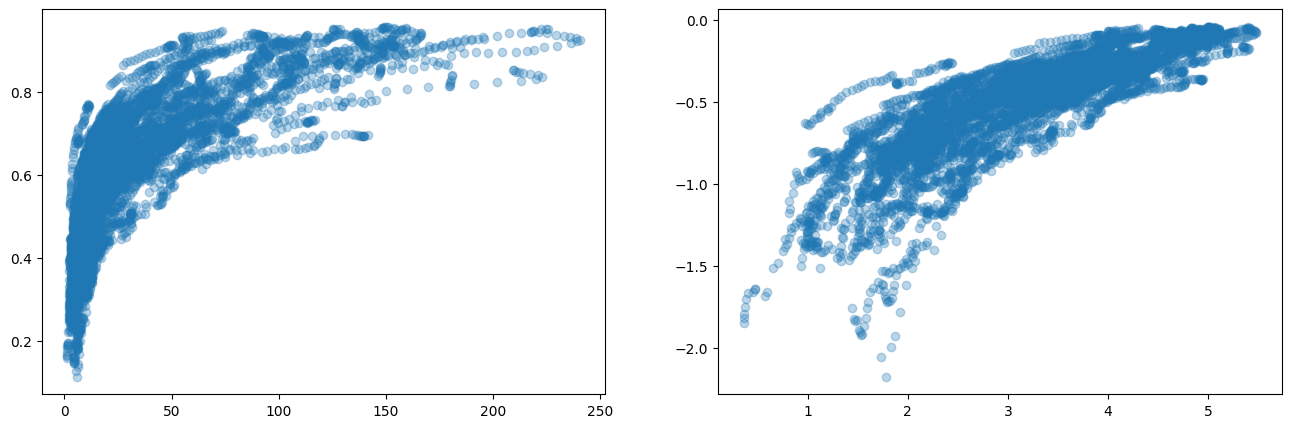

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].scatter(df[x], df[y], alpha=0.3)
ax[1].scatter(np.log(df[x]), np.log(df[y]), alpha=0.3)

In [141]:
data = Data(
    obs=y,
    obs_se="se"
)

In [143]:
priors = [
    SplinePriorGetter(UniformPrior(lb=0.0, ub=1.0), order=0, size=20),
    SplinePriorGetter(UniformPrior(lb=0.0, ub=np.inf), order=1, size=20),
    SplinePriorGetter(UniformPrior(lb=-np.inf, ub=0.0), order=2, size=20)
]

variables = [
    SplineVariable(x,
                   spline=SplineGetter(knots=np.linspace(0.0, 1.0, 7),
                                       degree=2,
                                       r_linear=True,
                                       l_linear=True,
                                       knots_type="rel_freq",
                                       include_first_basis=True),
                   priors=priors)
]

In [144]:
model = SFMAModel(data, variables)
model.attach(df)

In [145]:
model.fit(outlier_pct=0.05, trim_verbose=True, trim_max_iter=15, trim_step_size=2.0,
          eta_options={"method": "bounded", "bounds": [0.0, 1.0]})

trim_counter=  0, obj=1.63e+03, trim_error=1.00e+00
trim_counter=  1, obj=1.59e+03, trim_error=6.99e+00
trim_counter=  2, obj=-4.20e+03, trim_error=1.15e+01
trim_counter=  3, obj=-4.39e+03, trim_error=5.45e+00
trim_counter=  4, obj=-4.59e+03, trim_error=4.80e+00
trim_counter=  5, obj=-5.10e+03, trim_error=4.38e+00
trim_counter=  6, obj=-5.28e+03, trim_error=5.53e+00
trim_counter=  7, obj=-5.42e+03, trim_error=4.90e+00
trim_counter=  8, obj=-5.48e+03, trim_error=4.89e+00
trim_counter=  9, obj=-5.52e+03, trim_error=3.71e+00
trim_counter= 10, obj=-5.54e+03, trim_error=3.28e+00
trim_counter= 11, obj=-5.55e+03, trim_error=2.89e+00
trim_counter= 12, obj=-5.56e+03, trim_error=2.21e+00
trim_counter= 13, obj=-5.56e+03, trim_error=2.33e+00
trim_counter= 14, obj=-5.57e+03, trim_error=2.62e+00
trim_counter= 15, obj=-5.59e+03, trim_error=2.81e+00


In [146]:
df_pred = pd.DataFrame({
    x: np.linspace(df[x].min(), df[x].max(), 100)
})
df_pred["pred"] = model.predict(df_pred)

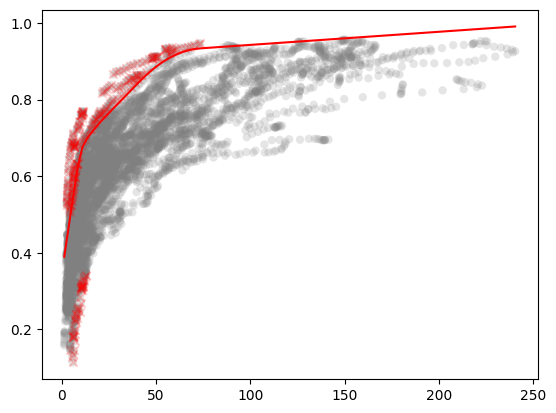

In [147]:
fig, ax = plt.subplots()
outlier_indices = model.weights == 0.0
ax.scatter(df[x], df[y], color="gray", edgecolor="none", alpha=0.2)
ax.scatter(df[x][outlier_indices], df[y][outlier_indices], color="red", marker="x", alpha=0.2)
ax.plot(df_pred[x], df_pred.pred, color="red")